In [29]:
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

def train_network():
    """ Train a Neural Network to generate music """
    notes = get_notes()

    # get amount of pitch names
    n_vocab = len(set(notes))

    network_input, network_output = prepare_sequences(notes, n_vocab)

    model = create_network(network_input, n_vocab)

    train(model, network_input, network_output)

def get_notes(source_path="midi_data/violin/*.mid", dest_path="notes_data/all_notes"):
    """ Get all the notes and chords from the midi files from  """
    notes = []
    for file in glob.glob(source_path):
        midi = converter.parse(file)
        print("Parsing %s" % file)
        notes_to_parse = None
        
        parts = instrument.partitionByInstrument(midi.getElementsByClass(stream.Part))

        if parts: # file has instrument parts
            notes_to_parse = parts.parts[0].recurse()
        else: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
            
     
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))    
        
    with open(dest_path, 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 100
    
    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)
    
    if np.any(network_output):
        network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return model

def train(model, network_input, network_output):
    """ train the neural network """
    filepath = "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.hdf5"
    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    history = model.fit(network_input,network_output, validation_split=0.20, epochs=200, batch_size=128, callbacks=callbacks_list)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



Parsing midi_data/violin/paganini_capriccio_14_(c)unknown.mid
Parsing midi_data/violin/paganini_capriccio_10_(c)unknown.mid
Parsing midi_data/violin/paganini_capriccio_1_(c)unknown.mid
Parsing midi_data/violin/SchubertDeathMaidenM1.mid
Parsing midi_data/violin/paganini_capriccio_3_(c)unknown.mid
Parsing midi_data/violin/SchubertDeathMaidenM2.mid
Parsing midi_data/violin/Beethoven-violin-sonata1-1-violin 2.mid
Parsing midi_data/violin/paganini_capriccio_2_(c)unknown.mid
Parsing midi_data/violin/Beethoven-violin-sonata1-1-violin.mid
Epoch 1/200
39/39 [==============================] - 313s 8s/step - loss: 5.1695 - accuracy: 0.0217 - val_loss: 4.8844 - val_accuracy: 0.0243
Epoch 2/200
39/39 [==============================] - 344s 9s/step - loss: 4.7621 - accuracy: 0.0427 - val_loss: 4.5881 - val_accuracy: 0.0138
Epoch 3/200
39/39 [==============================] - 270s 7s/step - loss: 4.4733 - accuracy: 0.0431 - val_loss: 4.1588 - val_accuracy: 0.0842
Epoch 4/200
39/39 [==================

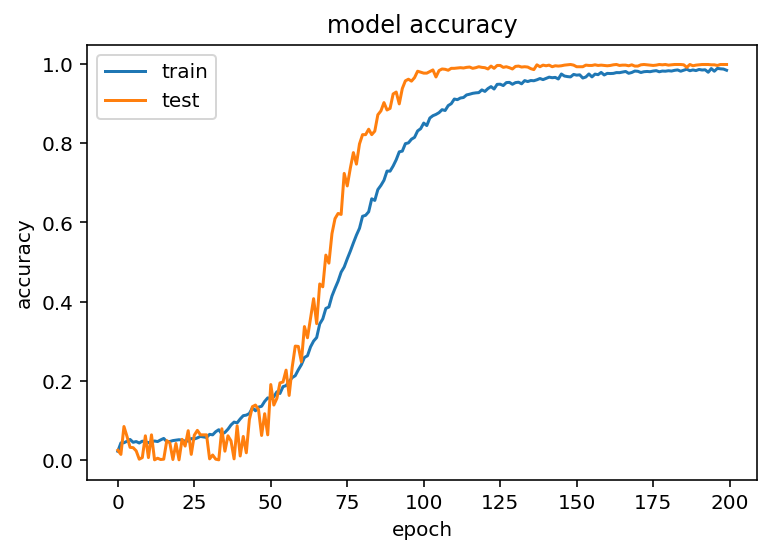

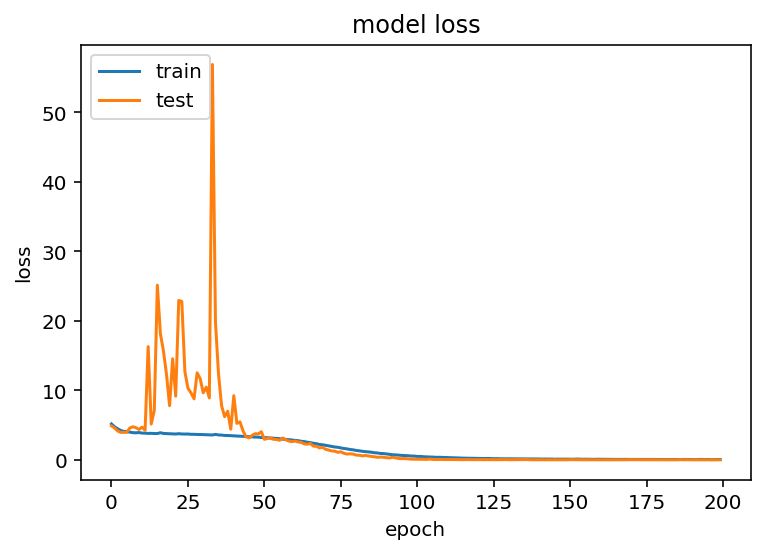

In [30]:
train_network()

In [33]:
get_notes()

Parsing midi_data/violin/paganini_capriccio_14_(c)unknown.mid
Parsing midi_data/violin/paganini_capriccio_10_(c)unknown.mid
Parsing midi_data/violin/paganini_capriccio_1_(c)unknown.mid
Parsing midi_data/violin/SchubertDeathMaidenM1.mid
Parsing midi_data/violin/paganini_capriccio_3_(c)unknown.mid
Parsing midi_data/violin/SchubertDeathMaidenM2.mid
Parsing midi_data/violin/Beethoven-violin-sonata1-1-violin 2.mid
Parsing midi_data/violin/paganini_capriccio_2_(c)unknown.mid
Parsing midi_data/violin/Beethoven-violin-sonata1-1-violin.mid


['2.7',
 '7.10',
 'A5',
 'B-5',
 'A5',
 'G5',
 'F5',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F#4',
 'G4',
 'G3',
 'A3',
 'B-3',
 'C4',
 'D4',
 'E-4',
 'C#4',
 'D4',
 'C4',
 'B-3',
 'A3',
 '2.7',
 '7.10',
 'A5',
 'B-5',
 'A5',
 'G5',
 'F5',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F#4',
 'G4',
 'G3',
 'A3',
 'B-3',
 'C4',
 'D4',
 'E-4',
 'C#4',
 'D4',
 'C4',
 'B-3',
 'A3',
 'G3',
 'G4',
 'A4',
 'F#4',
 'G4',
 'F4',
 'E-4',
 'D4',
 'C4',
 'C5',
 'D5',
 'B4',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F4',
 'F5',
 'G5',
 'E5',
 'F5',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'B-5',
 'C6',
 'A5',
 'B-5',
 'A5',
 'G#5',
 'G5',
 'F#5',
 'F#4',
 'F5',
 'F4',
 'E5',
 'E4',
 'E-5',
 'E-4',
 'D5',
 'D4',
 'C#5',
 'C#4',
 'D4',
 'E-4',
 'C#4',
 'D4',
 'F#4',
 'A4',
 'D5',
 'D4',
 'E-4',
 'D4',
 'C4',
 'B-3',
 'A3',
 '2.7',
 '7.10',
 'A5',
 'B-5',
 'A5',
 'G5',
 'F5',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F#4',
 'G4',
 'G3',
 'A3',
 'B-3',
 'C4',
 'D4',
 'E-4',
 'C#4',
 'D4',
 'C4',
 'B-3',
 'A3',
 '2

In [32]:
 %run predict.py

ValueError: Shapes (256, 4) and (256, 104) are incompatible

In [3]:
get_notes()

Parsing midi_data/violin/paganini_capriccio_14_(c)unknown.mid
Parsing midi_data/violin/paganini_capriccio_10_(c)unknown.mid
Parsing midi_data/violin/paganini_capriccio_1_(c)unknown.mid
Parsing midi_data/violin/SchubertDeathMaidenM1.mid
Parsing midi_data/violin/paganini_capriccio_3_(c)unknown.mid
Parsing midi_data/violin/SchubertDeathMaidenM2.mid
Parsing midi_data/violin/Beethoven-violin-sonata1-1-violin 2.mid
Parsing midi_data/violin/paganini_capriccio_2_(c)unknown.mid
Parsing midi_data/violin/Beethoven-violin-sonata1-1-violin.mid


['2.7',
 '7.10',
 'A5',
 'B-5',
 'A5',
 'G5',
 'F5',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F#4',
 'G4',
 'G3',
 'A3',
 'B-3',
 'C4',
 'D4',
 'E-4',
 'C#4',
 'D4',
 'C4',
 'B-3',
 'A3',
 '2.7',
 '7.10',
 'A5',
 'B-5',
 'A5',
 'G5',
 'F5',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F#4',
 'G4',
 'G3',
 'A3',
 'B-3',
 'C4',
 'D4',
 'E-4',
 'C#4',
 'D4',
 'C4',
 'B-3',
 'A3',
 'G3',
 'G4',
 'A4',
 'F#4',
 'G4',
 'F4',
 'E-4',
 'D4',
 'C4',
 'C5',
 'D5',
 'B4',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F4',
 'F5',
 'G5',
 'E5',
 'F5',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'B-5',
 'C6',
 'A5',
 'B-5',
 'A5',
 'G#5',
 'G5',
 'F#5',
 'F#4',
 'F5',
 'F4',
 'E5',
 'E4',
 'E-5',
 'E-4',
 'D5',
 'D4',
 'C#5',
 'C#4',
 'D4',
 'E-4',
 'C#4',
 'D4',
 'F#4',
 'A4',
 'D5',
 'D4',
 'E-4',
 'D4',
 'C4',
 'B-3',
 'A3',
 '2.7',
 '7.10',
 'A5',
 'B-5',
 'A5',
 'G5',
 'F5',
 'E-5',
 'D5',
 'C5',
 'B-4',
 'A4',
 'G4',
 'F#4',
 'G4',
 'G3',
 'A3',
 'B-3',
 'C4',
 'D4',
 'E-4',
 'C#4',
 'D4',
 'C4',
 'B-3',
 'A3',
 '2